# Preamble

In [72]:
using ForwardDiff, Plots, LaTeXStrings, DifferentialEquations, Roots, QuadGK

In [1]:
Mpl = 2.435e18; # reduced Planck mass in GeV
c = 299792458; # speed of light in m/s
KinGeV = (1.160e4)^-1 * 10^-9; # Kelvin in GeV
Mpcinm = 3.086e16 * 10^6; # Mpc in m
GeVinminv = 10^9/(1.973e-7); # GeV in m^-1
GeVinMpcinv = GeVinminv * Mpcinm; # GeV in Mpc^-1
MpcinvinHz = c/Mpcinm; # Mpc^inv in Hz
yrins = 365.2422 * 24 * 60 * 60; # yr in s

Or0h2 = 4.2e-5; # current radiation density parameter * h^2
Hubblh = 0.674; # normalised Hubble parameter h

T0 = 2.725*KinGeV; # current temperature
grho0 = 3.383; # current grho
gs0 = 3.931; # current gs

In [2]:
Threads.nthreads()

10

# Background

In [3]:
ai = [1, 1.11724, 3.12672e-1, -4.68049e-2, -2.65004e-2, -1.19760e-3, 1.82812e-4, 1.36436e-4, 8.55051e-5, 1.22840e-5, 3.82259e-7, -6.87035e-9];
bi = [1.43382e-2, 1.37559e-2, 2.92108e-3, -5.38533e-4, -1.62496e-4, -2.87906e-5, -3.84278e-6, 2.78776e-6, 7.40342e-7, 1.17210e-7, 3.72499e-9, -6.74107e-11];
ci = [1, 6.07869e-1, -1.54485e-1, -2.24034e-1, -2.82147e-2, 2.90620e-2, 6.86778e-3, -1.00005e-3, -1.69104e-4, 1.06301e-5, 1.69528e-6, -9.33311e-8];
di = [7.07388e1, 9.18011e1, 3.31892e1, -1.39779, -1.52558, -1.97857e-2, -1.60146e-1, 8.22615e-5, 2.02651e-2, -1.82134e-5, 7.83943e-5, 7.13518e-5];

In [4]:
Tth = 0.12; # temperature separation in GeV

In [5]:
grhohigh(T) = sum([ai[i]*log(T)^(i - 1) for i=1:12]) / sum([bi[i]*log(T)^(i - 1) for i=1:12]); # eff. DoF for energy density for T > 0.12 GeV
gshigh(T) = grhohigh(T) / (1 + sum([ci[i]*log(T)^(i - 1) for i=1:12]) / sum([di[i]*log(T)^(i - 1) for i=1:12])); # eff. DoF for entropy for T > 0.12 GeV

In [6]:
rhohigh(T) = π^2/30*grhohigh(T)*T^4; # energy density for T > 0.12 GeV
shigh(T) = 2*π^2/45*gshigh(T)*T^3; # entropy for T > 0.12 GeV
phigh(T) = T*shigh(T) - rhohigh(T); # pressure for T > 0.12 GeV

In [7]:
# some fitting functions
Sfit(x) = 1 + 7/4*exp(-1.0419*x) * (1 + 1.034*x + 0.456426*x^2 + 0.0595249*x^3);
frho(x) = exp(-1.04855*x) * (1 + 1.03757*x + 0.508630*x^2 + 0.0893988*x^3);
brho(x) = exp(-1.03149*x) * (1 + 1.03317*x + 0.398264*x^2 + 0.0648056*x^3);
fs(x) = exp(-1.04190*x) * (1 + 1.03400*x + 0.456426*x^2 + 0.0595248*x^3);
bs(x) = exp(-1.03365*x) * (1 + 1.03397*x + 0.342548*x^2 + 0.0506182*x^3);

In [8]:
# mass params. in GeV
me = 511e-6;
mmu = 0.1056;
mpi0 = 0.13;
mpipm = 0.140;
m1 = 0.5;
m2 = 0.77;
m3 = 1.2;
m4 = 2;

In [9]:
# neutrino temperature
Tnu(T) = (4/11)^(1/3) * Sfit(me/T)^(1/3) * T;

In [10]:
grhogammalow(T) = 2.030 + 3.495*frho(me/T) + 3.446*frho(mmu/T) + 1.05*brho(mpi0/T) + 2.08*brho(mpipm/T) + 4.165*brho(m1/T) + 30.55*brho(m2/T) + 89.4*brho(m3/T) + 8209*brho(m4/T); # eff. DoF for photon energy density for T < 0.12 GeV
gsgammalow(T) = 2.008 + 3.442*fs(me/T) + 3.468*fs(mmu/T) + 1.034*bs(mpi0/T) + 2.068*bs(mpipm/T) + 4.16*bs(m1/T) + 30.55*bs(m2/T) + 90*bs(m3/T) + 6209*bs(m4/T); # eff. DoF for photon entropy for T < 0.12 GeV
grhonulow(T) = 1.353*Sfit(me/T)^(4/3); # eff. DoF for neutrino energy density for T < 0.12 GeV
gsnulow(T) = 1.923*Sfit(me/T); # eff. DoF for neutrino entropy for T < 0.12 GeV

In [11]:
# T < 0.12 GeV
rhogammalow(T) = π^2/30*grhogammalow(T)*T^4; # photon energy density
sgammalow(T) = 2*π^2/45*gsgammalow(T)*T^3; # photon entropy
rhonulow(T) = π^2/30*grhonulow(T)*T^4; # neutrino energy density
snulow(T) = 2*π^2/45*gsnulow(T)*T^3; # neutrino entropy
pgammalow(T) = T*sgammalow(T) - rhogammalow(T); # photon pressure
pnulow(T) = Tnu(T)*snulow(T) - rhonulow(T); # neutrino pressure
rholow(T) = rhogammalow(T) + rhonulow(T); # total energy density
plow(T) = pgammalow(T) + pnulow(T); # total pressure

In [14]:
ForwardDiff.derivative(grhohigh,1)

11.009177740245022

In [15]:
function grho(T) # eff. DoF for energy density
    if T >= Tth
        return grhohigh(T)
    else
        return grhogammalow(T) + grhonulow(T)
    end
end;

function grhop(T) # T-derivative of grho
    if T >= Tth
        return ForwardDiff.derivative(grhohigh,T)
    else
        return (ForwardDiff.derivative(grhogammalow,T) + 
            ForwardDiff.derivative(grhonulow,T))
    end
end;

function gs(T) # eff. DoF for entropy
    if T >= Tth
        return gshigh(T)
    else
        return gsgammalow(T) + gsnulow(T)
    end
end;

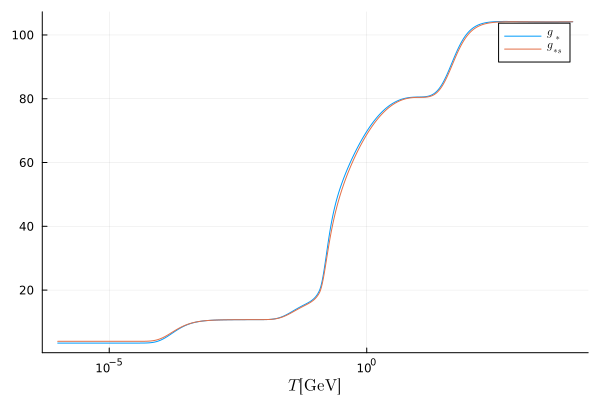

In [21]:
Tlist = [10^i for i=-6:0.01:4]
plot(grho, Tlist, xscale=:log10, label=L"$g_*$", xlabel=L"$T\,[\mathrm{GeV}]$")
plot!(gs, Tlist, label=L"$g_{*s}$")

In [22]:
function rho(T) # energy density
    if T >= Tth
        return rhohigh(T)
    else 
        return rholow(T)
    end
end;

function press(T) # pressure
    if T >= Tth
        return phigh(T)
    else
        return plow(T)
    end
end;

In [23]:
EoSw(T) = press(T)/rho(T); # equation-of-state param. w

function cs2(T) # sound speed squared
    if T >= Tth
        return ForwardDiff.derivative(phigh,T)/ForwardDiff.derivative(rhohigh,T)
    else
        return ForwardDiff.derivative(plow,T)/ForwardDiff.derivative(rholow,T)
    end
end;

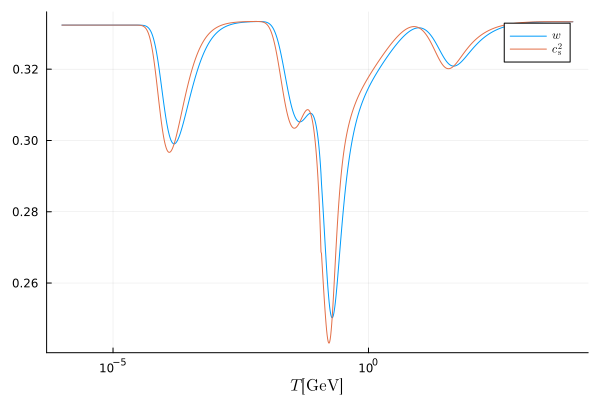

In [24]:
plot(EoSw, Tlist, xscale=:log10, label=L"$w$", xlabel=L"$T\,[\mathrm{GeV}]$")
plot!(cs2, Tlist, label=L"$c_\mathrm{s}^2$")

In [25]:
T0 = 2.725*KinGeV; # current temperature
grho0 = grho(T0); # current grho
gs0 = gs(T0); # current gs

In [26]:
calH(T, scalea) = scalea * sqrt(rho(T)/3/Mpl^2) * GeVinMpcinv; # conformal Hubble in Mpc^-1

In [27]:
Ti = 1e6; # initial temperature
scaleai = (gs0/gs(Ti))^(1/3)*T0/Ti; # temporal initial scale factor 
etai = 1/calH(Ti, scaleai); # initial conformal time

etaf = 10; # final conformal time

In [28]:
etai

5.842207902333349e-14

In [30]:
function bgEoM(du,u,p,lneta) # u[1] = T, u[2] = scalea
    du[1] = -3*exp(lneta)*(1 + EoSw(u[1])) * calH(u[1], u[2]) * grho(u[1]) / (grhop(u[1]) + 4*grho(u[1])/u[1])
    du[2] = exp(lneta)*u[2]*calH(u[1],u[2])
end;

ui = [Ti,scaleai];
lnetaspan = (log(etai),log(etaf));
bgprob = ODEProblem(bgEoM,ui,lnetaspan);
@time bgsol = solve(bgprob,Tsit5(),reltol=1e-10,abstol=1e-10);

  0.450188 seconds (5.22 M allocations: 135.322 MiB, 4.20% gc time, 72.98% compilation time)


In [31]:
Tsol(eta) = bgsol(log(eta))[1];
asol(eta) = bgsol(log(eta))[2];

In [56]:
norm = Tsol(etaf)/T0*asol(etaf); # renormalisation factor so that a0 = 1
etainorm = etai*norm;
etafnorm = etaf*norm;
aint(eta) = asol(eta/norm)/norm; # renormalised scale factor
Tint(eta) = Tsol(eta/norm); # T with the renormalised eta
calHint(eta) = calH(Tnorm(eta), anorm(eta)); # calH with the renormalised eta
rhoQint(eta) = rho(Tnorm(eta))^(1/4);
# af = anorm(norm*etaf); # renormalised scale factor at the final time
# calHf = calHnorm(norm*etaf); # calH at the final time

In [57]:
(aint(etafnorm),T0/Tsol(etaf))

(2.1330191783792356e-5, 2.1330191783792356e-5)

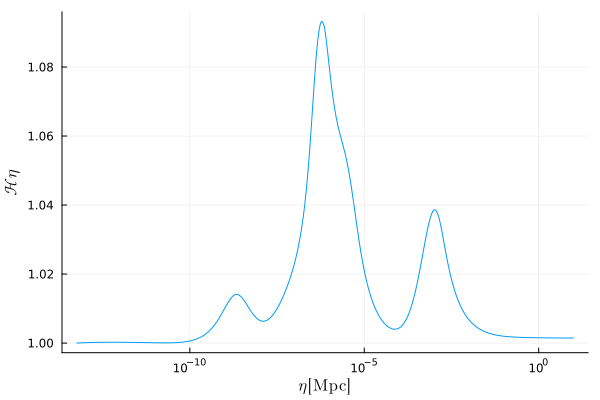

In [58]:
etalist = [10^i for i=log10(etainorm):0.01:log10(etafnorm)];
plot(etalist, map(x -> x*calHint(x), etalist), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}\eta$", legend=false)

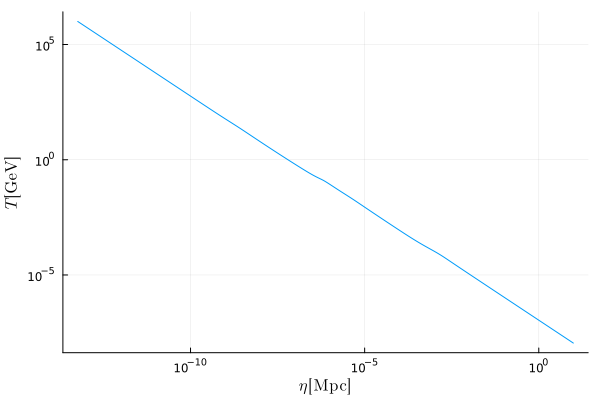

In [59]:
plot(Tint, etalist, xscale=:log10, yscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$T\,[\mathrm{GeV}]$", legend=false)

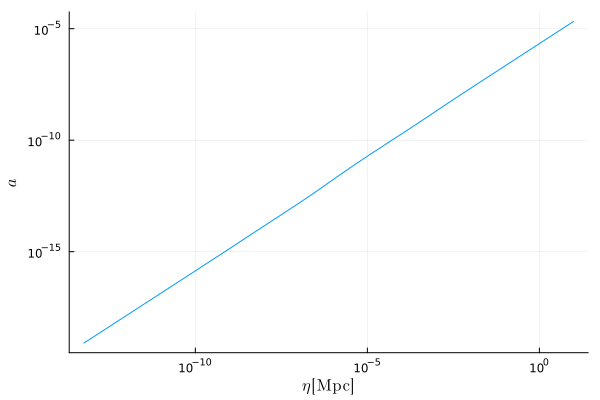

In [60]:
plot(aint, etalist, xscale=:log10, yscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$a$", legend=false)

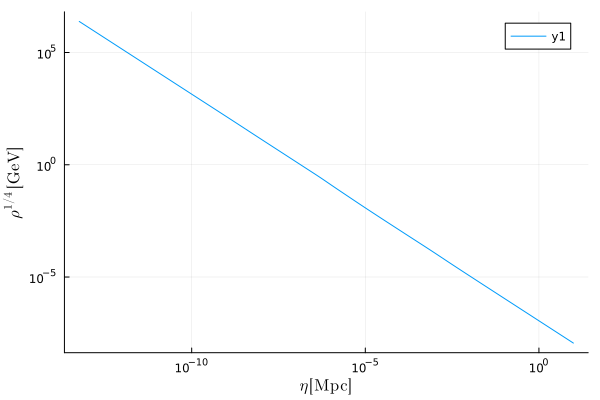

In [61]:
plot(rhoQint, etalist, xscale=:log10, yscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\rho^{1/4}\,[\mathrm{GeV}]$")

In [62]:
EoSwint(eta) = EoSw(Tnorm(eta));
cs2int(eta) = cs2(Tnorm(eta));
grhoint(eta) = grho(Tnorm(eta));
gsint(eta) = gs(Tnorm(eta));

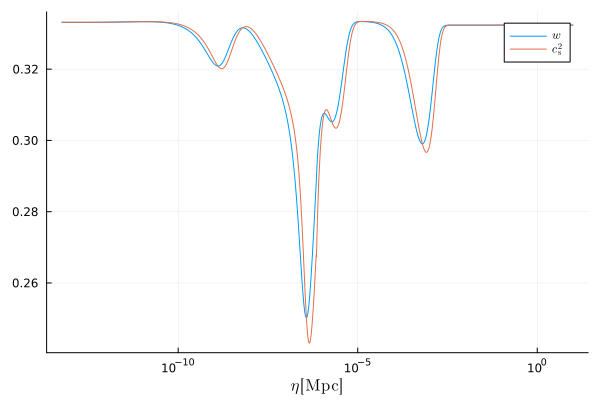

In [102]:
plot(EoSwint, etalist, xscale=:log10, label=L"$w$", xlabel=L"$\eta\,[\mathrm{Mpc}]$")
plot!(cs2int, etalist, label=L"$c_\mathrm{s}^2$")

In [67]:
frkH(eta) = calHint(eta)*(1+cs2int(eta));

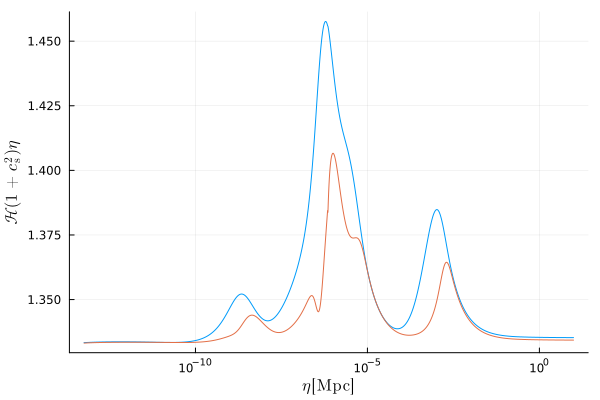

In [71]:
plot(etalist, map(x -> x*calHint(x)*(1+1/3), etalist), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}(1+c_\mathrm{s}^2)\eta$", legend=false)
plot!(etalist, map(x -> x*frkH(x), etalist))

In [63]:
rhoQis1e4(eta) = rhoQint(eta) - 1e4;
eta1e4 = find_zero(rhoQis1e4, (etainorm,1e-9))

1.3990721574405065e-11

In [64]:
(rhoQint(eta1e4), EoSwint(eta1e4), cs2int(eta1e4))

(10000.000000000013, 0.33331897239417807, 0.33332907441085496)

In [65]:
aint(eta1e4)

1.927432210988474e-17

# Scalar

## calculation

In [104]:
etainew = 1e-12;
etalist = [10^i for i=log10(etainew):0.01:log10(etafnorm)];

In [112]:
k = 1e4;

omegask2(eta) = cs2int(eta)*k^2 + 3*calHint(eta)^2*(cs2int(eta)-EoSwint(eta));

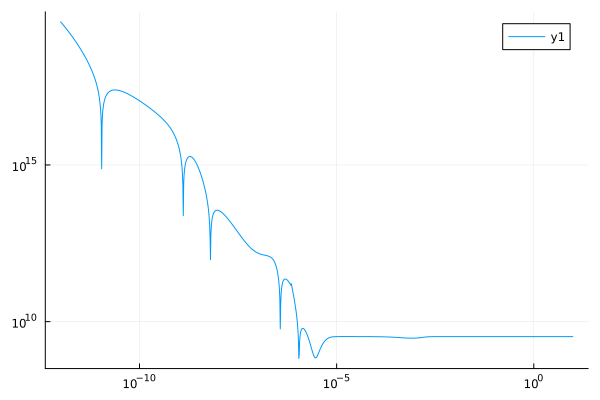

In [111]:
plot(omegask2, etalist, xscale=:log10, yscale=:log10)

In [100]:
omegask2(2e-10)

5.985816138263811e16